In [1]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns

# 设置全局字体
font_dirs = ['/public/home/mowp/test/fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'


In [2]:
import pandas as pd
import numpy as np
import pybedtools
import pyranges as pr
from scipy import stats

In [3]:
# get last pa sites
# get single polya site gene

last_pa_bed = '/public/home/mowp/workspace/termination/cbRNA_pool/polya_sites/cbRNA.last_polya_cluster_summit.bed'
last_pa = pr.read_bed(last_pa_bed, as_df=True)
last_pa.columns = ['Chromosome', 'Start', 'End', 'Name', 'Score', 'Strand', 'ratio']
last_pa.loc[:, 'Chromosome'] = last_pa.loc[:, 'Chromosome'].astype('str')

mask = last_pa.loc[:, 'Name'].str.contains('_1')
single_pa_site_gene = last_pa[mask].loc[:, 'Name'].map(lambda x: x.split('_')[0])

last_pa['Name'] = last_pa['Name'].map(lambda x: x.split('_')[0])
last_pa = last_pa.set_index(['Name'])


gene_model_bed = '/public/home/mowp/db/Arabidopsis_thaliana/isoform/araport11.gene.bed'
gene_model = pr.read_bed(gene_model_bed, as_df=True)

# get protein-coding gene

protein_coding_bed = '/public/home/mowp/db/Arabidopsis_thaliana/bed/Araport11_protein_coding.201606.bed'
protein_coding = pr.read_bed(protein_coding_bed, as_df=True)

protein_coding_gene = set(protein_coding['Name'].map(lambda x: x.split('.')[0]))

In [4]:
def get_target_site(site_type, gene_id):
    if site_type == 'PAS':
        # 获取基因PAS
        return last_pa.at[gene_id, 'End']
    elif site_type == 'TSS':
        # 获取基因TSS
        # array(['1', 3629, 5899, '.', '+'], dtype=object)
        try:
            values = tss_bed.loc[gene_id, :].values
            if values[4] == '+':
                return values[1]
            else:
                return values[2]
        except KeyError:
            values = gene_model.loc[gene_id, :].values
            if values[4] == '+':
                return values[1]
            else:
                return values[2]
            
    elif site_type == 'TES':
        # 获取基因TES
        # array(['1', 3629, 5899, '.', '+'], dtype=object)
        return int(merge_read_through_len.query('gene_id == @gene_id')['tts'])
    else:
        raise KeyError

In [5]:
%store -r cb_pool_read_through_len

In [6]:
all_gene = set(cb_pool_read_through_len['gene_id'])

In [7]:
def bed_intersect(a, b):
    intersect = a.intersect(b)
    return len(intersect)

# get downstream region

In [8]:
upstream_list, downstream_list, gene_body_list = [], [], []
distance = 1000  # 1000
for item in gene_model.values:
    chrom, start, end, gene_id, _, strand = item
    if gene_id not in all_gene:
        continue

    pas = get_target_site('PAS', gene_id)
    if gene_id not in protein_coding_gene:
        continue
    if start-distance < 0:
        continue
    if strand == '+':
        upstream_list.append(' '.join((chrom, str(start-distance), str(start-50), gene_id)))
        downstream_list.append(' '.join((chrom, str(pas+50), str(pas+distance), gene_id)))
    else:
        upstream_list.append(' '.join((chrom, str(end+50), str(end+distance), gene_id)))
        downstream_list.append(' '.join((chrom, str(pas-distance), str(pas-50), gene_id)))

    gene_body_list.append(' '.join((chrom, str(start), str(end), gene_id)))


In [9]:
upstream_list = pybedtools.BedTool('\n'.join(upstream_list), from_string=True)
downstream_list = pybedtools.BedTool('\n'.join(downstream_list), from_string=True)
gene_body_list = pybedtools.BedTool('\n'.join(gene_body_list), from_string=True)

# downstream with pre-tRNA

## different kind of gene

In [10]:
upstream_list, downstream_list, gene_body_list = [], [], []
distance = 200
for item in gene_model.values:
    chrom, start, end, gene_id, _, strand = item
    if gene_id not in all_gene:
        continue

    pas = get_target_site('PAS', gene_id)
    if gene_id not in protein_coding_gene:
        continue
    if start-distance < 0:
        continue
    if strand == '+':
        upstream_list.append(' '.join((chrom, str(start-distance), str(start-1), gene_id, '.', strand)))
        downstream_list.append(' '.join((chrom, str(pas+1), str(pas+distance), gene_id, '.', strand)))
    else:
        upstream_list.append(' '.join((chrom, str(end+1), str(end+distance), gene_id, '.', strand)))
        downstream_list.append(' '.join((chrom, str(pas-distance), str(pas-1), gene_id, '.', strand)))

    gene_body_list.append(' '.join((chrom, str(start), str(end), gene_id, '.', strand)))


In [11]:
upstream_list = pybedtools.BedTool('\n'.join(upstream_list), from_string=True)
downstream_list = pybedtools.BedTool('\n'.join(downstream_list), from_string=True)
gene_body_list = pybedtools.BedTool('\n'.join(gene_body_list), from_string=True)

In [12]:
infile = '/public/home/mowp/db/Arabidopsis_thaliana/isoform/araport11.gene.bed'
araport11_gene = pybedtools.BedTool(infile)

In [13]:
downstream = downstream_list.intersect(araport11_gene, wa=True, wb=True).to_dataframe()
downstream = downstream[['name', 'strand', 'blockCount', 'blockStarts']]
downstream.columns = ['upstream_gene', 'upstream_strand', 'downstream_gene', 'downstream_strand']

In [14]:
# get pre_trna_gene

infile = '/public/home/mowp/db/Arabidopsis_thaliana/Araport11_gene_type'
gene_type = pd.read_csv(infile, sep='\t', comment='!')
pre_trna_gene = set(gene_type.query('gene_model_type == "pre_trna"')['name'])
# pre_trna_gene = set(gene_type.query('gene_model_type == "transposable_element_gene"')['name'])

In [15]:
# Get downstream genes with tRNA

downstream_with_trna = set(downstream.query('downstream_gene in @pre_trna_gene')['upstream_gene'])
downstream_with_other_gene = set(downstream.query('downstream_gene not in @pre_trna_gene and upstream_gene != downstream_gene')['upstream_gene'])

In [16]:
%store downstream_with_other_gene

Stored 'downstream_with_other_gene' (set)


In [18]:
trna_read_through_len = cb_pool_read_through_len.query('gene_id in @downstream_with_trna').copy()
trna_read_through_len['tts'] = trna_read_through_len['tts'].map(round)

In [19]:
downstream_ = downstream.query('downstream_gene in @pre_trna_gene')
trna_read_through_len = pd.merge(trna_read_through_len, downstream_, left_on='gene_id', right_on='upstream_gene')

In [21]:
trna_read_through_len = pd.merge(trna_read_through_len, gene_model, left_on='downstream_gene', right_on='Name')

In [22]:
%store trna_read_through_len

Stored 'trna_read_through_len' (DataFrame)


In [44]:
same_strand_distance, diff_strand_distance = [], []
for item in trna_read_through_len.itertuples():
    if item.upstream_strand == '+':
        distance = item.Start-item.tts
    else:
        distance = item.tts-item.End
            
    if item.upstream_strand == item.downstream_strand:
        same_strand_distance.append((item.gene_id, distance))
    else:
        diff_strand_distance.append((item.gene_id, distance))
        

In [45]:
same_strand_distance = pd.DataFrame(same_strand_distance, columns=['gene_id', 'distance'])
diff_strand_distance = pd.DataFrame(diff_strand_distance, columns=['gene_id', 'distance'])

In [46]:
%store same_strand_distance
%store diff_strand_distance

Stored 'same_strand_distance' (DataFrame)
Stored 'diff_strand_distance' (DataFrame)


In [27]:
bins = np.arange(0, 100, 1)

n = 35


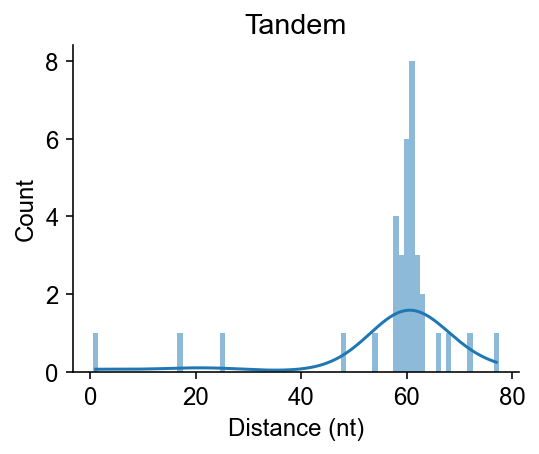

In [32]:
plt.figure(figsize=(4, 3))
data_ = same_strand_distance.query('distance > 0')
sns.histplot(data=data_, x="distance", kde=True, discrete=True, edgecolor=None)
# sns.histplot(data=data_, x="distance", element="poly", bins=bins)
sns.despine(top=True, right=True)

plt.xlabel('Distance (nt)')
plt.title('Tandem')
print(f'n = {len(data_)}')

n = 34


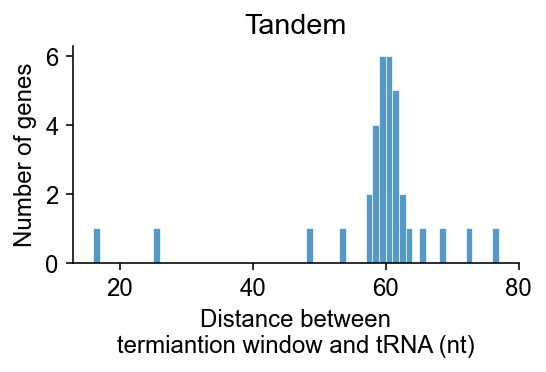

In [39]:
plt.figure(figsize=(4, 2))
data_ = same_strand_distance.query('distance > 0')
# sns.histplot(data=data_, x="distance", kde=True, bins=bins)
sns.histplot(data=data_, x="distance", binwidth=1, edgecolor='white')
sns.despine(top=True, right=True)

plt.xlabel('Distance between\ntermiantion window and tRNA (nt)')
plt.ylabel('Number of genes')
plt.title('Tandem')
print(f'n = {len(data_)}')

n = 35


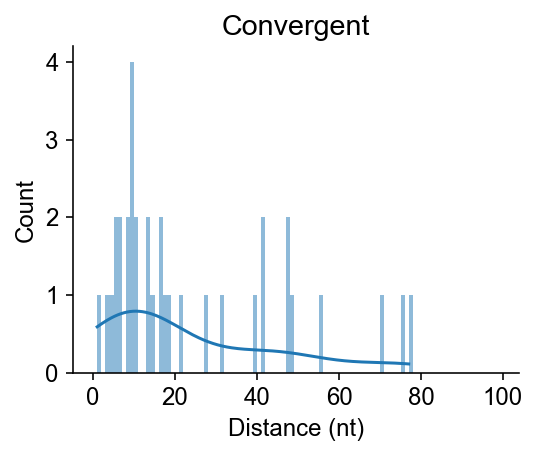

In [312]:
plt.figure(figsize=(4, 3))
data_ = diff_strand_distance.query('distance > 0')
sns.histplot(data=data_, x="distance", kde=True, bins=bins, edgecolor=None)
# sns.histplot(data=data_, x="distance", element="poly", bins=bins)
sns.despine(top=True, right=True)

plt.xlabel('Distance (nt)')
plt.title('Convergent')
print(f'n = {len(data_)}')

n = 35


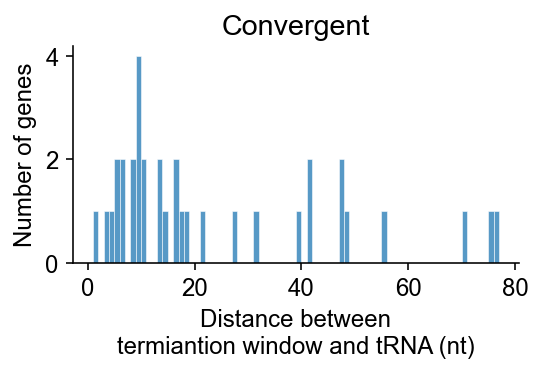

In [40]:
plt.figure(figsize=(4, 2))
data_ = diff_strand_distance.query('distance > 0')
# sns.histplot(data=data_, x="distance", kde=True, bins=bins)
sns.histplot(data=data_, x="distance", binwidth=1, edgecolor='white')
sns.despine(top=True, right=True)

plt.xlabel('Distance between\ntermiantion window and tRNA (nt)')
plt.ylabel('Number of genes')
plt.title('Convergent')
print(f'n = {len(data_)}')